# Perturbation notebooks
This notebook has been written to study the perturbations implemented cascade. We start with some imports: 

In [23]:
import cascade as csc
import numpy as np
import pykep as pk
import pickle as pkl
import heyoka as hy

%matplotlib notebook

import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

%matplotlib inline

# Taking a satellite from the catalogue

To select a satellite from our catalogue we have to first of all extract it from our catalogue in the data

In [24]:
# with open("../data/debris_simulation_ic_LEO_2022.pk", "rb") as file:
with open("../data/debris_simulation_ic_SSO_breakup.pk", "rb") as file:
    r, v, collision_radius, to_satcat_index, satcat, debris = pkl.load(file)

# reference epoch for the initial conditions
    # t0_jd = pk.epoch_from_iso_string("20220301T000000").jd # Julian date corresponding to 2022-Mar-01 00:00:00
    t0_jd = pk.epoch_from_iso_string("20231130T000000").jd # Julian date corresponding to 2023-Nov-30 00:00:00

# Prepare the data in the shape expected by the simulation object.
ic_state = np.hstack([r, v, collision_radius.reshape((r.shape[0], 1))])
collisional_step = 225

Excracting the IRIDIUM 7 (or the GALAXY 11 if we are in GEO, or the VANGUARD 2 if we are in SSO). OSS: in SSO we have 2 VANGUARD 2 satellites because of the way we build the initial conditions: in particular we copied elements inside the debris catalogue in order to have the bstar parameters of the debris particles. So it seems that we have two identical satellites, but this is only in the debris catalogue (and so in the bstar parameter).

In [25]:
idx_satellite = []
to_satcat_satellite = []
collision_radius_satellite = []
count = -1 # I want it to start from 0 because I need it to extract components from a vector. See later
i = 0

# extracting from satcat all the indexes of the objects called NOAA 16 DEB and append them in a vector
for deb in np.arange(len(to_satcat_index)):
    if satcat[to_satcat_index[deb]]["OBJECT_NAME"] == "VANGUARD 2":
    # if satcat[deb]["OBJECT_NAME"] == "GALAXY 11":
        idx_satellite.append(to_satcat_index[deb])
        count += 1
        # we retrieve the relative to_satcat index from the series of indexes we have just obtained
        while idx_satellite[count] != to_satcat_index[i]:
            i += 1
        to_satcat_satellite.append(i)
        
# proof that we are using the right indexes
for j in to_satcat_satellite:
    print(satcat[to_satcat_index[j]]["OBJECT_NAME"])
    print("altitude [m]: ", np.linalg.norm((ic_state[to_satcat_satellite, 0], ic_state[to_satcat_satellite, 1], ic_state[to_satcat_satellite, 2])) - pk.EARTH_RADIUS)

VANGUARD 2
altitude [m]:  3821376.259991128
VANGUARD 2
altitude [m]:  3821376.259991128


since we need at least two particles in the simulation with cascade, we will create a catalogue of 2 particles: one is IRIDIUM 7 and the other one can be selected randomly and it won't be used

In [26]:
par = to_satcat_satellite[0]
ic_state_new = np.vstack((ic_state[par], ic_state[0]))

# Create 2 simulations to compare

First of all we set up the Keplerian dynamics

In [27]:
kep_dyn =  csc.dynamics.simple_earth(J2=False, J3=False, J4=False, C22S22=False, sun=False, moon=False, SRP=False, drag=False)

# we now set up the simulation
kep_sim = csc.sim(ic_state_new, collisional_step, dyn=kep_dyn)

Then we set up the perturbed dynamics. You can turn on the kwarg you want here.

In [28]:
per_dyn =  csc.dynamics.simple_earth(J2=False, J3=False, J4=False, C22S22=False, sun=False, moon=True, SRP=False, drag=False)

We compute all the BSTAR parameters we need to pass to heyoka, we built the vector containing only the 2 particles of interest

In [29]:
# We now extract from the satcat list and store it into separate arrays the objects' BSTAR coefficients.
# Array containing the BSTAR coefficient in the SI units used
BSTARS = []
for idx in to_satcat_index:
    BSTARS.append(float(satcat[idx]["BSTAR"]))
# We transform the BSTAR in SI units
BSTARS = np.array(BSTARS) / pk.EARTH_RADIUS
# .. and remove negative BSTARS (this can happen for objects that where performing orbital manouvres during the tle definition) setting the value to zero in those occasions.
BSTARS[BSTARS<0] = 0.

#drag
p0 = BSTARS.reshape((r.shape[0], 1)) # BSTAR coefficient (SI units) 
p0_new = np.vstack((p0[par], p0[0]))

We now compute the runtime parameters for the SRP

In [30]:
# srp runtime paremeter
# Volume of all satellites starting from the collision radius
volume = (4/3) * (np.pi) * ((collision_radius.reshape((r.shape[0], 1))) ** 3) # [m^3]

# iridium satellite charateristics
mass_iridium = 689 # [kg] (mass of a first-generation Iridium satellite)
radius_iridium = 1.0281416736168953 # [m] (radius of a first-generation Iridium satellite)

# average density of the satellites
av_den = mass_iridium / ((4/3) * (np.pi) * (radius_iridium ** 3)) # [kg/m^3]

# we compute M for each debris
mass = av_den * volume # [m]

# computing the AOM for each satellite
A = (np.pi) * ((collision_radius.reshape((r.shape[0], 1))) ** 2)
AOM = A / mass

# defining p1 as cr * A/m with Cr = 1
p1 = 1 * AOM
p1_new = np.vstack((p1[par], p1[0]))

We plot the A/M for all the particles in the simulation

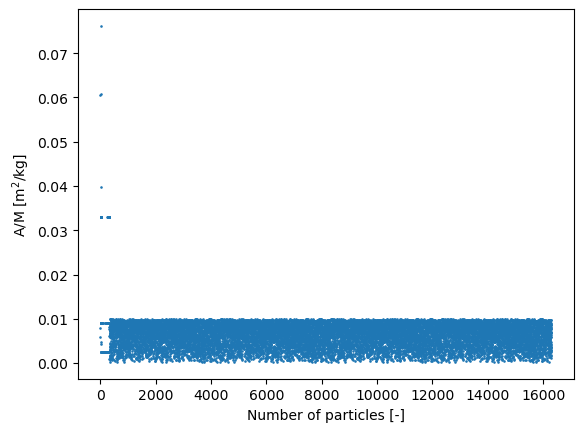

In [31]:
plt.scatter(range(len(AOM)), AOM, label = 'A/M', s = 0.75)

plt.xlabel('Number of particles [-]')
plt.ylabel('A/M [m$^2$/kg]')

# Save the image in high quality (adjust the filename and format as needed)
# plt.savefig('AOM.png', dpi=300, bbox_inches='tight')

plt.show()

Finally we compute the simulation

In [32]:
# we now set up the simulation
per_sim = csc.sim(ic_state_new, collisional_step, dyn=per_dyn) 
# in the case of the drag and of the SRP, remember to add the runtime parameters. example:
# per_sim = csc.sim(ic_state_new, collisional_step, dyn=per_dyn, pars = p0_new) 

# We propagate both the simulations for some orbits

Initializing initial and final time

In [33]:
# We define here the simulation starting time knowing that in the dynamics t=0 corresponds to 1st Jan 2000 12:00.
t0 = (t0_jd - pk.epoch_from_iso_string("20000101T120000").jd) * pk.DAY2SEC

# computing the osculating elements
el = pk.ic2par([ic_state[to_satcat_satellite, 0][0], ic_state[to_satcat_satellite, 1][0], ic_state[to_satcat_satellite, 2][0]], [ic_state[to_satcat_satellite, 3][0], ic_state[to_satcat_satellite, 4][0], ic_state[to_satcat_satellite, 5][0]], pk.MU_EARTH)
a = el[0]

# computing the period of the orbit
period = 2*np.pi * np.sqrt((a**3)/pk.MU_EARTH) # [s]

days = (10*period) * pk.SEC2DAY
time_step = 10 # s

We start computing the perturbed dynamics 

In [34]:
# Running the simulation for 10 days
final_t = t0 + (days * pk.DAY2SEC) 

per_sim.time = t0

per_pos = []
per_vel = []

per_x_acc = []
per_y_acc = []
per_z_acc = []

next_per_t = per_sim.time + time_step

# making the equations of the acceleration from the dynamics
per_ax_eq = hy.make_cfunc([per_dyn[3][1]])
per_ay_eq = hy.make_cfunc([per_dyn[4][1]])
per_az_eq = hy.make_cfunc([per_dyn[5][1]])

while per_sim.time < final_t:
    
    oc = per_sim.propagate_until(next_per_t)
    
    if oc == csc.outcome.time_limit:

        # collecting position and velocity
        per_pos.append(np.copy(per_sim.state[0][:3]))   
        per_vel.append(np.copy(per_sim.state[0][3:6]))

        # collecting the acceleration vector
        per_x_acc.append(per_ax_eq([per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], time = per_sim.time))
        per_y_acc.append(per_ay_eq([per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], time = per_sim.time))
        per_z_acc.append(per_az_eq([per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], time = per_sim.time))

        # # collecting the acceleration vector (case drag)
        # per_x_acc.append(per_ax_eq([per_sim.state[0][3], per_sim.state[0][4], per_sim.state[0][5], per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], pars = (p0_new[0]), time = per_sim.time))
        # per_y_acc.append(per_ay_eq([per_sim.state[0][3], per_sim.state[0][4], per_sim.state[0][5], per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], pars = (p0_new[0]), time = per_sim.time))
        # per_z_acc.append(per_az_eq([per_sim.state[0][3], per_sim.state[0][4], per_sim.state[0][5], per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], pars = (p0_new[0]), time = per_sim.time))

        # # collecting the acceleration vector (case srp)
        # per_x_acc.append(per_ax_eq([per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], pars = p1_new[0], time = per_sim.time))
        # per_y_acc.append(per_ay_eq([per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], pars = p1_new[0], time = per_sim.time))
        # per_z_acc.append(per_az_eq([per_sim.state[0][0], per_sim.state[0][1], per_sim.state[0][2]], pars = p1_new[0], time = per_sim.time))
        # pars = p1[to_satcat_IRIDIUM[0]]
        
        next_per_t += time_step # setting again the next_t

        continue # continue the simulation

# we build the vectors to plot them
per_x_pos = []
per_y_pos = []
per_z_pos = []

per_pos_norm = []
per_acc_norm = []

for i in range(len(per_pos)):
    per_x_pos.append(per_pos[i][0])
    per_y_pos.append(per_pos[i][1])
    per_z_pos.append(per_pos[i][2])

    per_pos_norm.append(np.linalg.norm((per_pos[i][0], per_pos[i][1], per_pos[i][2])))
    per_acc_norm.append(np.linalg.norm((per_x_acc[i], per_y_acc[i], per_z_acc[i])))

We then compute the keplerian dynamics with the states coming from the perturbed dynamics, because at the end we need to subtract this term to the main one to obtain only the perturbation

In [35]:
# Running the simulation for 10 days
final_t = t0 + (days * pk.DAY2SEC) 

kep_sim.time = t0
kep_pos = []
kep_vel = []

kep_x_acc = []
kep_y_acc = []
kep_z_acc = []
t_vec = []

k = 0

next_kep_t = kep_sim.time + time_step # time step 

# making the equations of the acceleration from the dynamics
kep_ax_eq = hy.make_cfunc([kep_dyn[3][1]])
kep_ay_eq = hy.make_cfunc([kep_dyn[4][1]])
kep_az_eq = hy.make_cfunc([kep_dyn[5][1]])

while kep_sim.time < final_t:
    
    oc = kep_sim.propagate_until(next_kep_t)
    
    if oc == csc.outcome.time_limit:

        # collecting position and velocity
        kep_pos.append(np.copy(kep_sim.state[0][:3]))   
        kep_vel.append(np.copy(kep_sim.state[0][3:6]))

        # collecting the acceleration vector
        kep_x_acc.append(kep_ax_eq([per_pos[k][0], per_pos[k][1], per_pos[k][2]]))
        kep_y_acc.append(kep_ay_eq([per_pos[k][0], per_pos[k][1], per_pos[k][2]]))
        kep_z_acc.append(kep_az_eq([per_pos[k][0], per_pos[k][1], per_pos[k][2]]))

        # we collect the time
        t_vec.append(kep_sim.time)
        
        next_kep_t += time_step # setting again the next_t

        k += 1
        
        continue # continue the simulation

# we build the vectors to plot them
kep_x_pos = []
kep_y_pos = []
kep_z_pos = []

kep_pos_norm = []
kep_acc_norm = []

for i in range(len(kep_pos)):
    
    kep_x_pos.append(kep_pos[i][0])
    kep_y_pos.append(kep_pos[i][1])
    kep_z_pos.append(kep_pos[i][2])

    kep_pos_norm.append(np.linalg.norm((kep_pos[i][0], kep_pos[i][1], kep_pos[i][2])))
    kep_acc_norm.append(np.linalg.norm((kep_x_acc[i], kep_y_acc[i], kep_z_acc[i])))

# We plot some plots

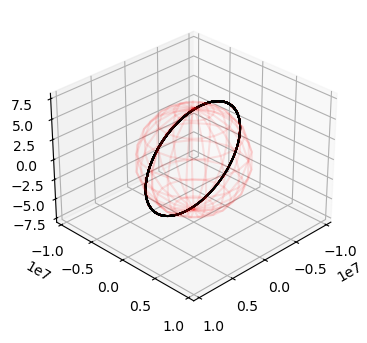

In [36]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

r_earth = pk.EARTH_RADIUS
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = r_earth*np.cos(u)*np.sin(v)
y = r_earth*np.sin(u)*np.sin(v)
z = r_earth*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

ax.scatter3D(kep_x_pos, kep_y_pos, kep_z_pos, s= 0.2, c='k')
ax.scatter3D(per_x_pos, per_y_pos, per_z_pos, s= 0.2, c='r')
ax.axis("equal")
ax.view_init(30, 45)

We generate the difference between the keplerian and the perturbed acceleration

In [37]:
diff_pos_norm=[]
diff_acc_norm=[]

for i in range(len(per_pos)):

    diff_pos_norm.append(np.linalg.norm(np.array([kep_pos[i][0], kep_pos[i][1], kep_pos[i][2]]) - np.array([per_pos[i][0], per_pos[i][1], per_pos[i][2]])))

# this is the array we need!!!!
    diff_acc_norm.append(np.linalg.norm(np.array([per_x_acc[i], per_y_acc[i], per_z_acc[i]]) - np.array([kep_x_acc[i], kep_y_acc[i], kep_z_acc[i]])))

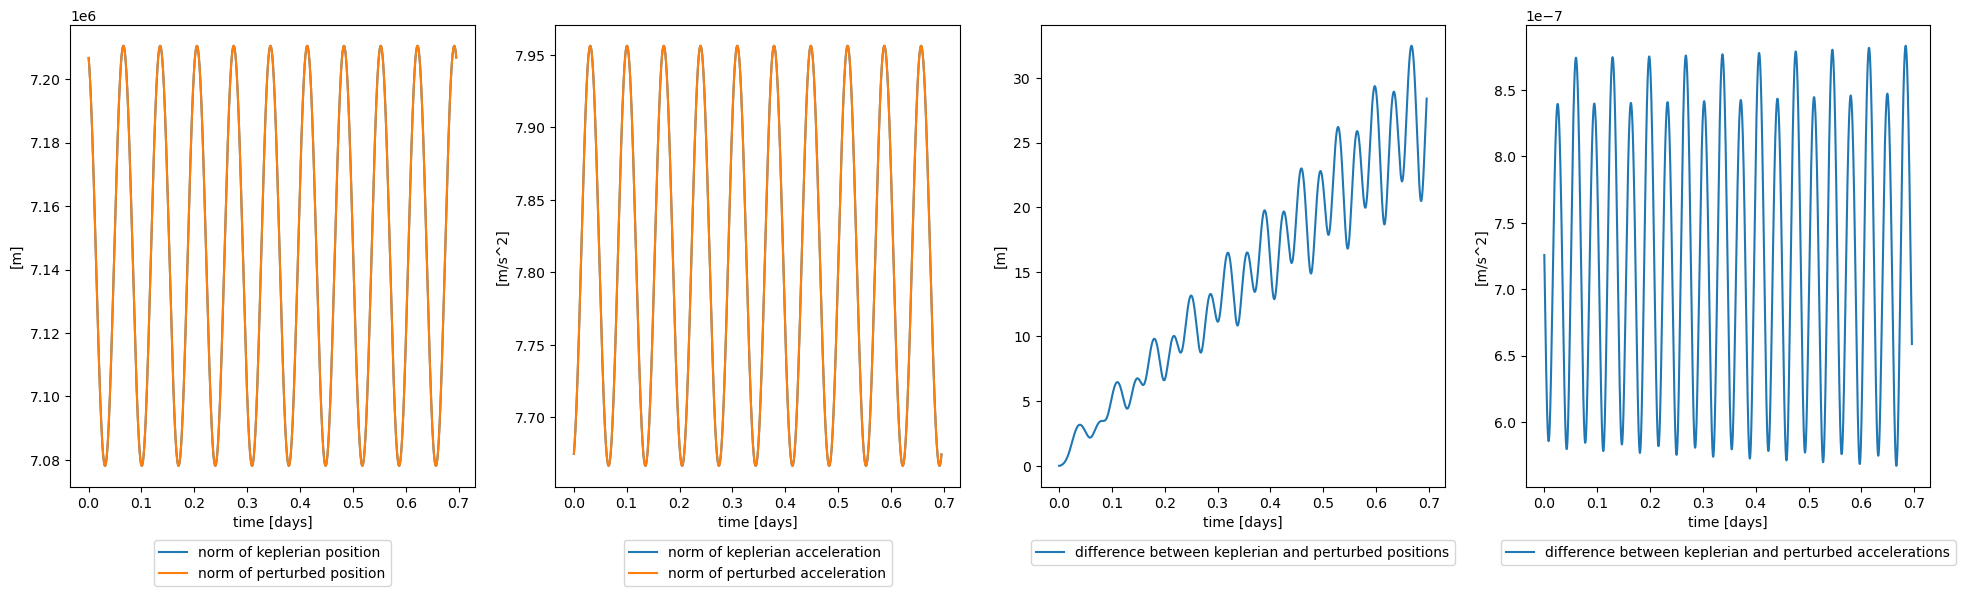

In [38]:
import matplotlib.pyplot as plt

# Create a figure and a subplot with 2 columns and 1 row
fig, axs = plt.subplots(1, 4, figsize = (24, 6))

# position
axs[0].plot((t_vec - t0*np.ones(len(t_vec)))*pk.SEC2DAY, kep_pos_norm, label = 'norm of keplerian position')
axs[0].plot((t_vec - t0*np.ones(len(t_vec)))*pk.SEC2DAY, per_pos_norm, label = 'norm of perturbed position')
axs[0].set_xlabel("time [days]")
axs[0].set_ylabel("[m]")

# Specify the position of the legend
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))

# acceleration 
axs[1].plot((t_vec - t0*np.ones(len(t_vec)))*pk.SEC2DAY, kep_acc_norm, label = 'norm of keplerian acceleration')
axs[1].plot((t_vec - t0*np.ones(len(t_vec)))*pk.SEC2DAY, per_acc_norm, label = 'norm of perturbed acceleration')
axs[1].set_xlabel("time [days]")
axs[1].set_ylabel("[m/s^2]")

# Specify the position of the legend
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))

# perturbed acceleration
axs[2].plot((t_vec - t0*np.ones(len(t_vec)))*pk.SEC2DAY, diff_pos_norm, label = 'difference between keplerian and perturbed positions')
axs[2].set_xlabel("time [days]")
axs[2].set_ylabel("[m]")

# Specify the position of the legend
axs[2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))


# perturbed acceleration
axs[3].plot((t_vec - t0*np.ones(len(t_vec)))*pk.SEC2DAY, diff_acc_norm, label = 'difference between keplerian and perturbed accelerations')
axs[3].set_xlabel("time [days]")
axs[3].set_ylabel("[m/s^2]")

# Specify the position of the legend
axs[3].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1))

# Show the plot
plt.show()


We plot the SRP acting on the particles to be sure we are doing right

In [39]:
# radius_sat = [1.0281416736168953, 0.19706294962377494, 0.3537338211973066, 2.0, 0.55, 2.0, 0.07046725639945928, 0.12666024736934256, 0.8816353617410082, 1.2163618630863422, 0.06932877671916071, 0.12231338704589192, 0.7241873849194098, 2.0, 0.55, 1.2213499169456303, 0.43720142572201925  ]
# SRP_prt = [2.2398068091689435e-08, 1.1687676379055665e-07, 6.510921929073025e-08, 1.1513553883008562e-08, 4.1867451651557286e-08, 1.1513981787288546e-08, 3.267920579390378e-07, 1.8181188790986503e-07, 2.6123938319556288e-08, 1.8934627886857052e-08, 3.3220965886983604e-07, 1.8826544882749662e-07, 3.1798159251903065e-08, 1.1514125020923404e-08, 4.186837276977807e-08, 1.885489688369057e-08, 5.2669890854086984e-08]
# SRP_prt = [value / 1000 for value in SRP_prt] # [km]
# len(SRP_prt)

In [40]:
# plt.scatter(SRP_prt, radius_sat, s = 10)

# plt.ylabel('Radius [m]')
# plt.xlabel('SRP [km/s$^2$]')
# plt.legend()

# # plt.savefig('SRP_particles.png', dpi=300, bbox_inches='tight')

# plt.show()

Finally, we save the file of the perturbations in the folder. At the end, when we will have all the files, we will plot everything as shown below

In [41]:
# with open("J2.pk", "wb") as file:
#     pkl.dump(kep_acc_norm, file)

# we plot all the perturbation

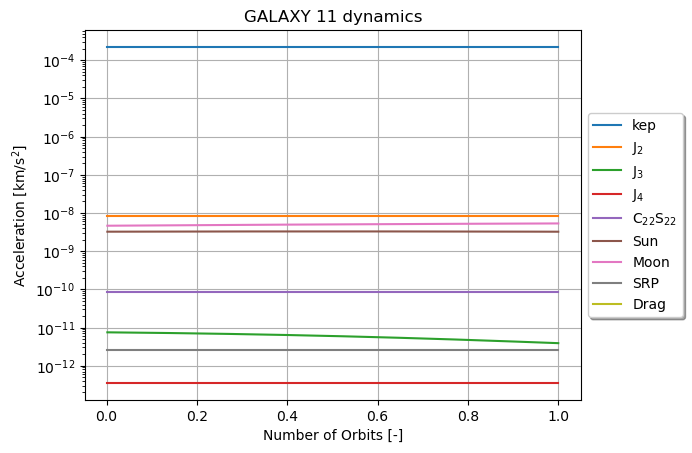

In [42]:
with open("keplerian.pk", "rb") as file:
    keplerian = pkl.load(file)

with open("J2.pk", "rb") as file:
    J2 = pkl.load(file)

with open("J3.pk", "rb") as file:
    J3 = pkl.load(file)

with open("J4.pk", "rb") as file:
    J4 = pkl.load(file)

with open("C22S22.pk", "rb") as file:
    C22S22 = pkl.load(file)

with open("sun.pk", "rb") as file:
    sun = pkl.load(file)

with open("moon.pk", "rb") as file:
    moon = pkl.load(file)

with open("SRP.pk", "rb") as file:
    SRP = pkl.load(file)

with open("drag.pk", "rb") as file:
    drag = pkl.load(file)

time = (t_vec - t0*np.ones(len(t_vec)))/period
time = time[:int(len(time)/10)] # since I propagated for 100 orbits (a lot), for the plot I want to consider only the first 10 

plt.plot(time, np.array(keplerian)[:int(len(time))]/1000, label = 'kep') # dividing by 1e3 to transform from m to km
plt.plot(time, np.array(J2)[:int(len(time))]/1000, label='J$_2$')
plt.plot(time, np.array(J3)[:int(len(time))]/1000, label='J$_3$')
plt.plot(time, np.array(J4)[:int(len(time))]/1000, label='J$_4$')
plt.plot(time, np.array(C22S22)[:int(len(time))]/1000, label='C$_{22}$S$_{22}$')
plt.plot(time, np.array(sun)[:int(len(time))]/1000, label = 'Sun')
plt.plot(time, np.array(moon)[:int(len(time))]/1000, label = 'Moon')
plt.plot(time, np.array(SRP)[:int(len(time))]/1000, label = 'SRP')
plt.plot(time, np.array(drag)[:int(len(time))]/1000, label = 'Drag')

plt.yscale('log')
plt.title('GALAXY 11 dynamics')
plt.xlabel('Number of Orbits [-]')
plt.ylabel('Acceleration [km/s$^2$]')
plt.grid(True)
# Add legend to the middle left with 9 rows
plt.legend(loc='center left', fancybox=True, shadow=True, ncol=1, bbox_to_anchor=(1, 0.5))

# # Save the image in high quality (adjust the filename and format as needed)
# plt.savefig('acceleration_plot.png', dpi=300, bbox_inches='tight')

plt.show()


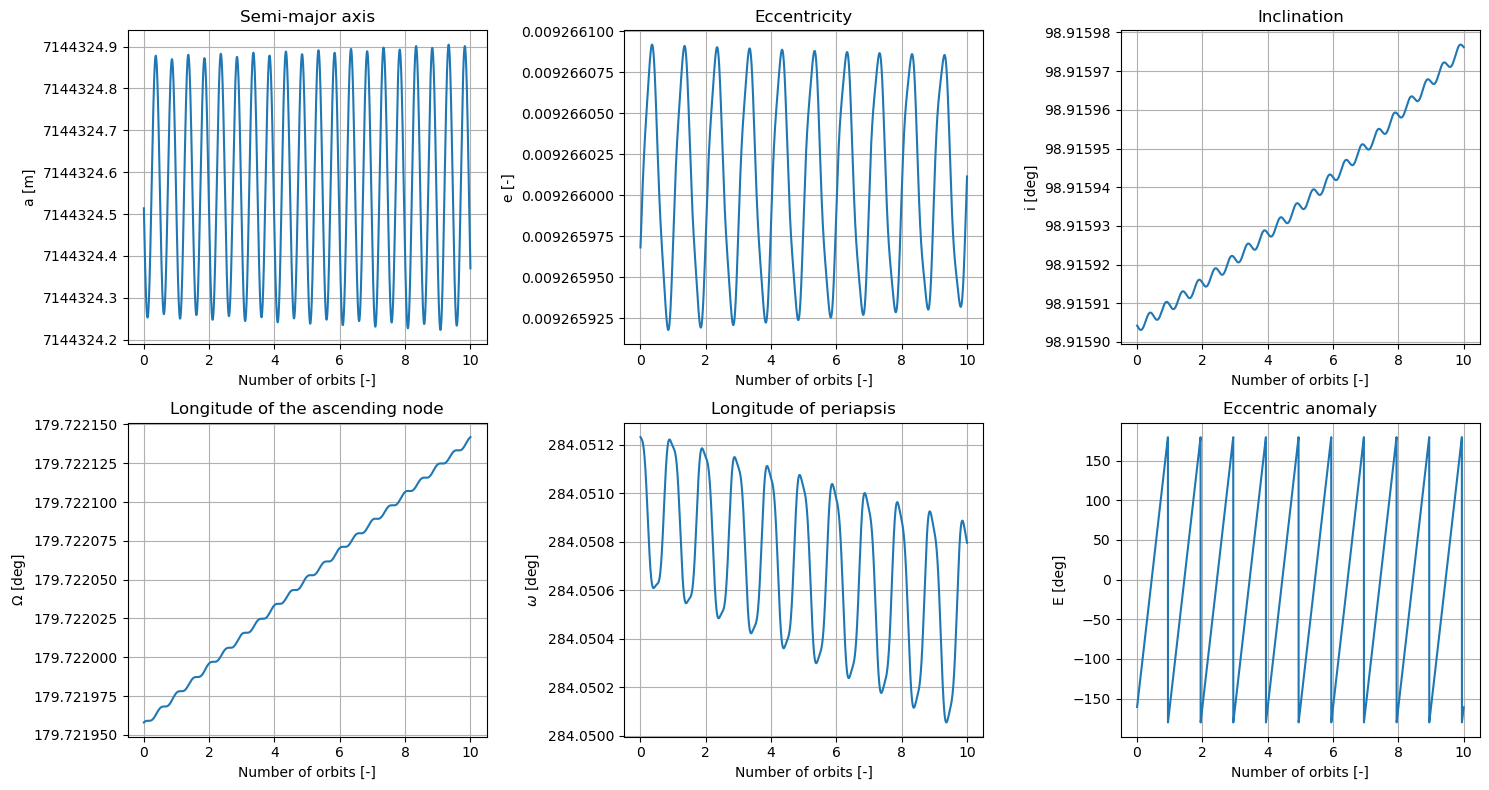

In [46]:
# computing the osculating elements
per_el = []
per_a = []
per_e = []
per_i = []
per_W = []
per_w = []
per_E = []

time = (t_vec - t0*np.ones(len(t_vec)))/period
time = time[:int(len(time))]

for i in range(len(time)):  
    per_el.append(pk.ic2par([per_pos[i][0], per_pos[i][1], per_pos[i][2]], [per_vel[i][0], per_vel[i][1], per_vel[i][2]], pk.MU_EARTH))
    per_a.append(np.copy(per_el[i][0]))
    per_e.append(np.copy(per_el[i][1]))
    per_i.append(np.copy(per_el[i][2]))
    per_W.append(np.copy(per_el[i][3]))
    per_w.append(np.copy(per_el[i][4]))
    per_E.append(np.copy(per_el[i][5]))

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))

plt.subplot(2, 3, 1)
plt.plot(time, per_a)
plt.title('Semi-major axis')
plt.xlabel('Number of orbits [-]')
plt.ylabel('a [m]')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.subplot(2, 3, 2)
plt.plot(time, per_e)
plt.title('Eccentricity')
plt.xlabel('Number of orbits [-]')
plt.ylabel('e [-]')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.subplot(2, 3, 3)
plt.plot(time, np.rad2deg(per_i))
plt.title('Inclination')
plt.xlabel('Number of orbits [-]')
plt.ylabel('i [deg]')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.subplot(2, 3, 4)
plt.plot(time, np.rad2deg(per_W))
plt.title('Longitude of the ascending node')
plt.xlabel('Number of orbits [-]')
plt.ylabel(r'$\Omega$ [deg]')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.subplot(2, 3, 5)
plt.plot(time, np.rad2deg(per_w))
plt.title('Longitude of periapsis')
plt.xlabel('Number of orbits [-]')
plt.ylabel(r'$\omega$ [deg]')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.subplot(2, 3, 6)
plt.plot(time, np.rad2deg(per_E))
plt.title('Eccentric anomaly')
plt.xlabel('Number of orbits [-]')
plt.ylabel('E [deg]')
plt.grid(True)
plt.ticklabel_format(useOffset=False, style='plain', axis='y')

plt.tight_layout()  # Adjust layout to prevent overlapping

# Save the image in high quality (adjust the filename and format as needed)
# plt.savefig('elements_drag.png', dpi=300, bbox_inches='tight')

plt.show()